In [26]:
# this notebook is originally from Tim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hydra import initialize, compose
import torch

from numpy.lib import scimath as SM
from sklearn.preprocessing import quantile_transform

from case_studies.dc2_cataloging.utils.notebook_plotting_params import NoteBookPlottingParams
from bliss.surveys.dc2 import DC2DataModule
from hydra.utils import instantiate
from bliss.catalog import FullCatalog, TileCatalog
from pathlib import Path

# in Tim and Shreyas data, objects don't have flux less than 200
base_flux_bin_cutoffs = [400, 600, 800, 1000]
mag_bin_labels = ["< 23.9", "[23.9, 24.1]", "[24.1, 24.5]",
                  "[24.5, 24.9]", "[24.9, 25.6]"]
tile_slen = 4
image_lim = 4000
sub_image_len = 100
bands = ("u", "g", "r", "i", "z", "y")

output_dir = Path("./plot_output/")
output_dir.mkdir(parents=True, exist_ok=True)

with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [27]:
def get_mag_bin_labels(flux: np.ndarray, flux_bin_cutoffs, mag_bin_labels):
    flux_bin_indexes = np.digitize(flux, flux_bin_cutoffs)
    mag_bin_indexes = len(mag_bin_labels) - flux_bin_indexes - 1
    return np.take_along_axis(np.array(mag_bin_labels), 
                              indices=mag_bin_indexes, 
                              axis=0)

In [28]:
# load in catalog, take subset for computational efficiency, drop nans
# since we still can't run the generate_catalog.ipynb, we use the catalog from Tim and Shreyas
cat = pd.read_pickle("/data/scratch/dc2local/dc2_lensing_catalog.pkl")
# cat = cat.sample(n = int(1e5))

In [29]:
cat.columns

Index(['mag_z', 'mag_y', 'id', 'mag_i', 'flux_r', 'dec', 'ra', 'mag_u',
       'cosmodc2_id', 'truth_type', 'mag_g', 'redshift', 'flux_y', 'flux_z',
       'flux_i', 'flux_g', 'flux_u', 'match_objectId', 'mag_r', 'Iyy_pixel',
       'IxyPSF_pixel_u', 'IxxPSF_pixel_u', 'IxxPSF_pixel_z', 'IxyPSF_pixel_g',
       'IyyPSF_pixel_u', 'IxxPSF_pixel_y', 'IxyPSF_pixel_i', 'IxxPSF_pixel_i',
       'IyyPSF_pixel_i', 'IyyPSF_pixel_r', 'psf_fwhm_u', 'IxyPSF_pixel_r',
       'psf_fwhm_r', 'psf_fwhm_z', 'IxyPSF_pixel_z', 'Ixy_pixel',
       'IyyPSF_pixel_y', 'IxyPSF_pixel_y', 'psf_fwhm_i', 'IxxPSF_pixel_r',
       'Ixx_pixel', 'IyyPSF_pixel_g', 'psf_fwhm_g', 'psf_fwhm_y',
       'IxxPSF_pixel_g', 'IyyPSF_pixel_z', 'convergence', 'galaxy_id',
       'ellipticity_2_true', 'ellipticity_1_true', 'shear_2', 'shear_1'],
      dtype='object')

In [30]:
cat.dropna(subset=["id", "cosmodc2_id", "match_objectId", 
                    "ra", "dec",
                    "flux_r",
                    "Ixx_pixel", "Ixy_pixel", "Iyy_pixel",
                    "ellipticity_1_true", "ellipticity_2_true"], 
           inplace=True)
cat["mag_bin"] = get_mag_bin_labels(cat["flux_r"], base_flux_bin_cutoffs, mag_bin_labels)
cat["mag_bin"] = pd.Categorical(cat["mag_bin"], categories=mag_bin_labels, ordered=True)

In [31]:
# this is the function from https://github.com/LSSTDESC/DC2-analysis/blob/master/validation/validate_dc2_run2.2i_object_table.ipynb
# thank Tim for finding this useful repos
def ellipticity(I_xx, I_xy, I_yy):
    """Calculate ellipticity from second moments.

    Parameters
    ----------
    I_xx : float or numpy.array
    I_xy : float or numpy.array
    I_yy : float or numpy.array

    Returns
    -------
    e, e1, e2 : (float, float, float) or (numpy.array, numpy.array, numpy.array)
        Complex ellipticity, real component, imaginary component
        
    Copied from https://github.com/lsst/validate_drp/python/lsst/validate/drp/util.py
    """
    e = (I_xx - I_yy + 2j * I_xy) / (I_xx + I_yy + 2 * SM.sqrt(I_xx * I_yy - I_xy * 2))
    e1 = np.real(e)
    e2 = np.imag(e)
    return e, e1, e2

In [32]:
est_ellip, est_ellip1, est_ellip2 = ellipticity(cat["Ixx_pixel"].values, 
                                                cat["Ixy_pixel"].values, 
                                                cat["Iyy_pixel"].values)
cat["ellipticity_est"] = est_ellip
cat["ellipticity_1_est"] = est_ellip1
cat["ellipticity_2_est"] = est_ellip2
est_theta = np.arctan2(est_ellip2, est_ellip1)
est_theta = np.where(est_theta > 0, est_theta, np.pi + est_theta)
cat["ellipticity_theta_est"] = est_theta
true_theta = np.arctan2(cat["ellipticity_2_true"], 
                        cat["ellipticity_1_true"])
true_theta = np.where(true_theta > 0, true_theta, np.pi + true_theta)
cat["ellipticity_theta_true"] = true_theta
# cat = cat.loc[cat["ellipticity_theta_true"] < np.pi / 2]

In [33]:
# cat["ellipticity_theta_est"] += np.pi * 1.5
# cat["ellipticity_1_est"] = np.abs(cat["ellipticity_est"]) * np.cos(cat["ellipticity_theta_est"])
# cat["ellipticity_2_est"] = np.abs(cat["ellipticity_est"]) * np.sin(cat["ellipticity_theta_est"])

In [34]:
cat["ellipticity_true_abs"] = np.sqrt(cat["ellipticity_1_true"] ** 2 + 
                                      cat["ellipticity_2_true"] ** 2)
cat["ellipticity_est_abs"] = np.abs(cat["ellipticity_est"])

In [35]:
# cat["ellipticity_true_abs"] = quantile_transform(np.sqrt(cat["ellipticity_1_true"].values.reshape((-1, 1)) ** 2 + 
#                                                          cat["ellipticity_2_true"].values.reshape((-1, 1)) ** 2), 
#                                                  output_distribution="normal").reshape((-1, ))
# cat["ellipticity_true_abs"] /= (cat["ellipticity_true_abs"].max() - cat["ellipticity_true_abs"].min()) * 5
# cat["ellipticity_theta_true"] = quantile_transform(cat["ellipticity_theta_true"].values.reshape((-1, 1)), output_distribution="normal").reshape((-1, ))

# cat["ellipticity_est_abs"] = quantile_transform(np.abs(cat["ellipticity_est"].values.reshape((-1, 1))), output_distribution="normal").reshape((-1, ))
# cat["ellipticity_est_abs"] /= (cat["ellipticity_est_abs"].max() - cat["ellipticity_est_abs"].min()) * 5
# # cat["ellipticity_theta_est"] = quantile_transform(cat["ellipticity_theta_est"].values.reshape((-1, 1)), output_distribution="normal").reshape((-1, ))

In [36]:
# cat["ellipticity_1_est"] = cat["ellipticity_est_abs"] * np.cos(cat["ellipticity_theta_true"])
# cat["ellipticity_2_est"] = cat["ellipticity_est_abs"] * np.sin(cat["ellipticity_theta_true"])
# cat["ellipticity_1_true"] = cat["ellipticity_true_abs"] * np.cos(cat["ellipticity_theta_true"])
# cat["ellipticity_2_true"] = cat["ellipticity_true_abs"] * np.sin(cat["ellipticity_theta_true"])

In [37]:
print(np.corrcoef(cat["ellipticity_1_true"], cat["ellipticity_1_est"]))
print(np.corrcoef(cat["ellipticity_2_true"], cat["ellipticity_2_est"]))
print(np.corrcoef(cat["ellipticity_est_abs"], cat["ellipticity_true_abs"]))
print(np.corrcoef(cat["ellipticity_theta_est"], cat["ellipticity_theta_true"]))

[[ 1.00000000e+00 -7.22960443e-04]
 [-7.22960443e-04  1.00000000e+00]]
[[1.00000000e+00 9.10414226e-05]
 [9.10414226e-05 1.00000000e+00]]
[[1.         0.44718125]
 [0.44718125 1.        ]]
[[1.00000000e+00 3.25435469e-04]
 [3.25435469e-04 1.00000000e+00]]


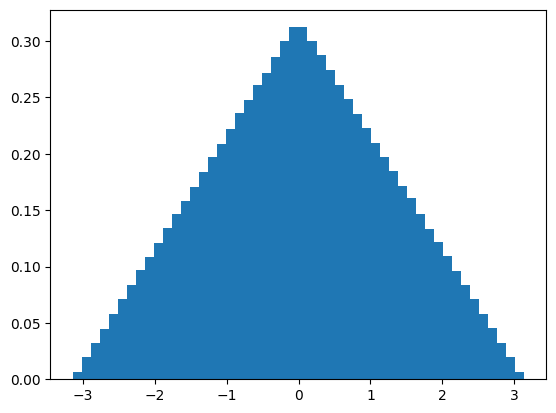

In [39]:
plt.hist(cat["ellipticity_theta_est"] - cat["ellipticity_theta_true"], density=True, bins=50)
plt.show()

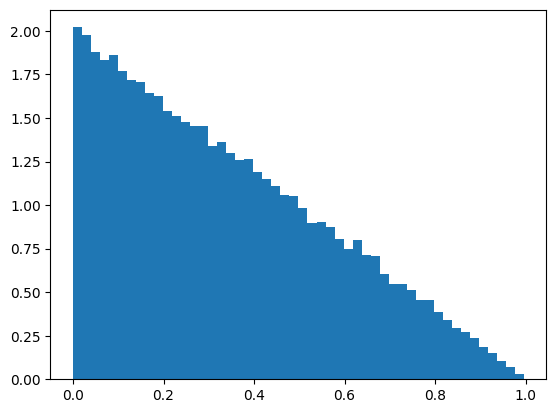

In [42]:
plt.hist(np.abs(np.random.rand(100000) - np.random.rand(100000)), density=True, bins=50)
plt.show()

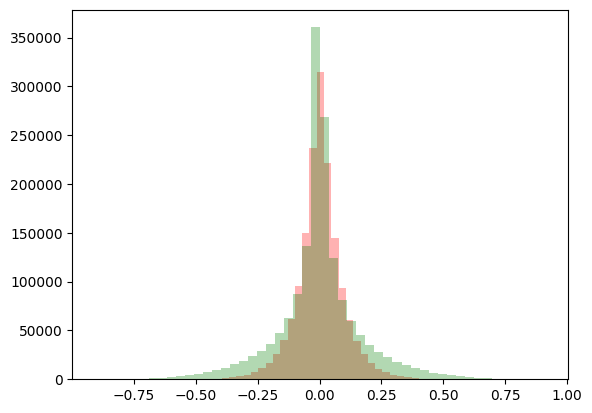

In [13]:
plt.hist(cat["ellipticity_1_est"], alpha=0.3, color="red", bins=50)
plt.hist(cat["ellipticity_1_true"], alpha=0.3, color="green", bins=50)
plt.show()

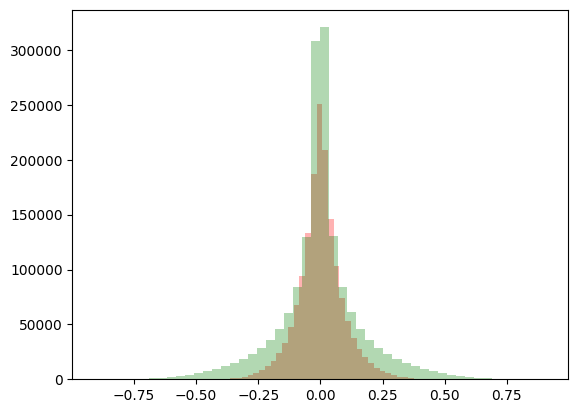

In [14]:
plt.hist(cat["ellipticity_2_est"], alpha=0.3, color="red", bins=50)
plt.hist(cat["ellipticity_2_true"], alpha=0.3, color="green", bins=50)
plt.show()

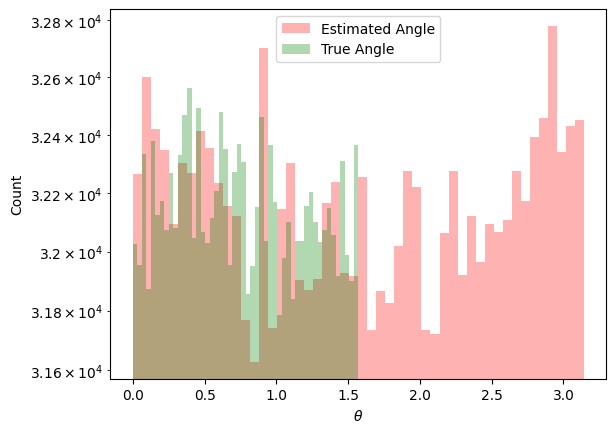

In [15]:
plt.hist(cat["ellipticity_theta_est"], alpha=0.3, log=True, color="red", bins=50, label="Estimated Angle")
plt.hist(cat["ellipticity_theta_true"], alpha=0.3, log=True, color="green", bins=50, label="True Angle")
plt.xlabel(r"$\theta$")
plt.ylabel("Count")
plt.legend()
plt.show()

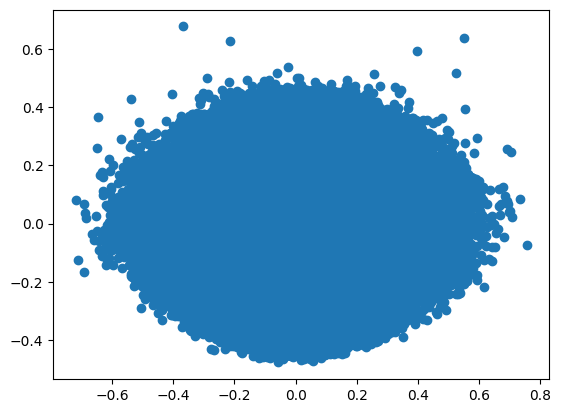

In [16]:
plt.scatter(cat["ellipticity_1_est"], cat["ellipticity_2_est"])
plt.show()

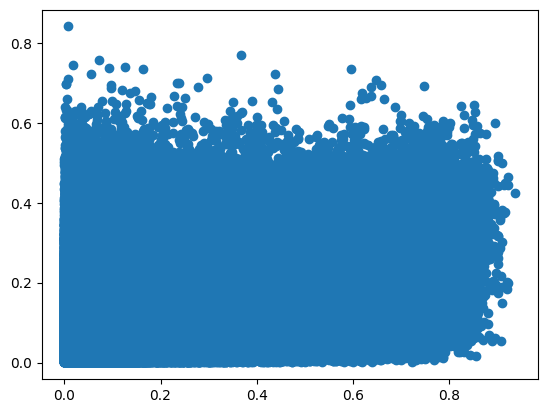

In [17]:
plt.scatter(np.sqrt(cat["ellipticity_1_true"] ** 2 + cat["ellipticity_2_true"] ** 2),
            np.abs(cat["ellipticity_est"]))
plt.show()

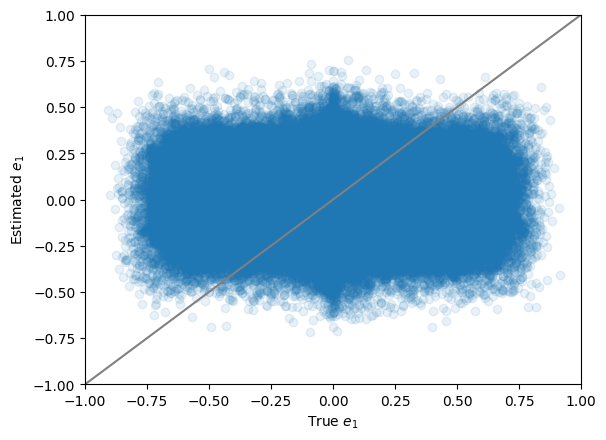

In [18]:
plt.scatter(cat["ellipticity_1_true"], cat["ellipticity_1_est"], alpha=0.1)
plt.axline([0, 0], [1, 1], color="grey")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("True $e_1$")
plt.ylabel("Estimated $e_1$")
plt.show()

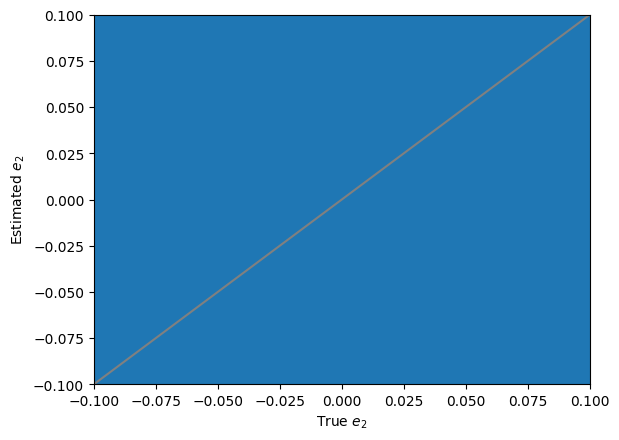

In [19]:
plt.scatter(cat["ellipticity_2_true"], cat["ellipticity_2_est"], alpha=0.1)
plt.axline([0, 0], [1, 1], color="grey")
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.xlabel("True $e_2$")
plt.ylabel("Estimated $e_2$")
plt.show()

In [20]:
def plot_ellipticity(e_num):
    nrows = 3
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                           figsize=(NoteBookPlottingParams.figsize[0] * ncols,
                                    NoteBookPlottingParams.figsize[1] * nrows),
                            sharex="col", sharey="row")
    for i, mag_bin in enumerate(mag_bin_labels):
        mag_bin_data = cat.loc[cat["mag_bin"] == mag_bin]
        ax = axes[i % nrows, i // nrows]
        ax.scatter(mag_bin_data[f"ellipticity_{e_num}_true"],
                    mag_bin_data[f"ellipticity_{e_num}_est"],
                    s=20.0,
                    alpha=0.005,
                    edgecolors="none",
                    color=NoteBookPlottingParams.color_dict["lsst"])
        ax.axline([0, 0], [1, 1], color="grey", alpha=0.5)
        ax.set_title("Magnitude " + mag_bin, fontsize=NoteBookPlottingParams.fontsize)
        ax.grid(visible=True, axis="y")
        ax.grid(visible=True, axis="x")

        ax.set_xlabel(f"True $e_{e_num}$", fontsize=NoteBookPlottingParams.fontsize)
        ax.tick_params(labelsize=NoteBookPlottingParams.fontsize)
        ax.set_ylabel(f"Estimated $e_{e_num}$", fontsize=NoteBookPlottingParams.fontsize)

        ax.set_xlim(-0.1, 0.1)
        ax.set_ylim(-0.1, 0.1)

    fig.tight_layout()

    return fig

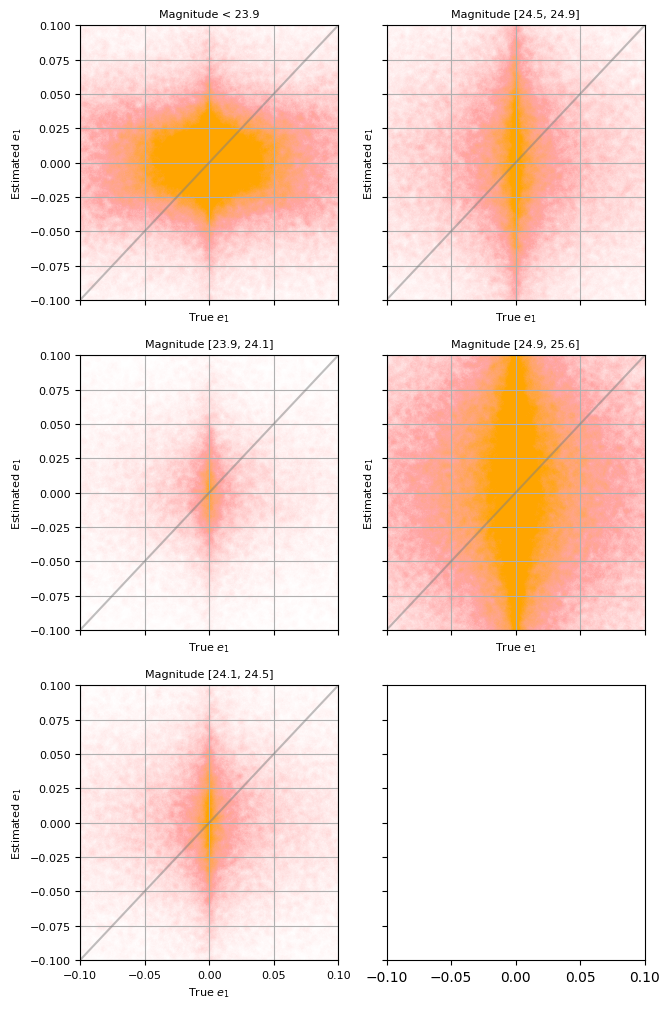

In [21]:
fig = plot_ellipticity(e_num=1)
fig.show()

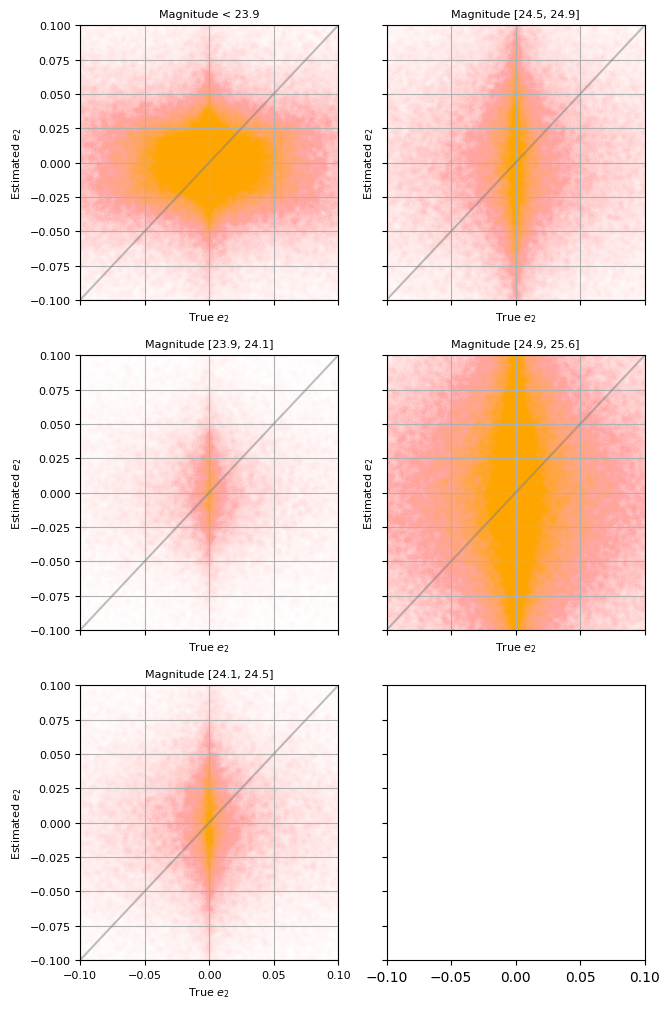

In [22]:
fig = plot_ellipticity(e_num=2)
fig.show()

In [23]:
def plot_ellipticity_qq_plot(e_num):
    nrows = 3
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                           figsize=(NoteBookPlottingParams.figsize[0] * ncols,
                                    NoteBookPlottingParams.figsize[1] * nrows),
                            sharex="col", sharey="row")
    percs = np.linspace(0, 100, 41)
    for i, mag_bin in enumerate(mag_bin_labels):
        mag_bin_data = cat.loc[cat["mag_bin"] == mag_bin]
        ax = axes[i % nrows, i // nrows]
        qn_true = np.percentile(mag_bin_data[f"ellipticity_{e_num}_true"], percs)
        qn_est = np.percentile(mag_bin_data[f"ellipticity_{e_num}_est"], percs)
        ax.scatter(qn_true,
                   qn_est,
                   s=20,
                   color=NoteBookPlottingParams.color_dict["lsst"])
        qn_min = np.min((qn_true.min(), qn_est.min()))
        qn_max = np.max((qn_true.max(), qn_est.max()))
        ax.axline([qn_min, qn_min], [qn_max, qn_max], color="grey", alpha=0.5)
        ax.set_title("Magnitude " + mag_bin, fontsize=NoteBookPlottingParams.fontsize)
        ax.grid(visible=True, axis="y")
        ax.grid(visible=True, axis="x")

        ax.set_xlabel(f"True $e_{e_num}$", fontsize=NoteBookPlottingParams.fontsize)
        ax.tick_params(labelsize=NoteBookPlottingParams.fontsize)
        ax.set_ylabel(f"Estimated $e_{e_num}$", fontsize=NoteBookPlottingParams.fontsize)

        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)

    fig.tight_layout()

    return fig

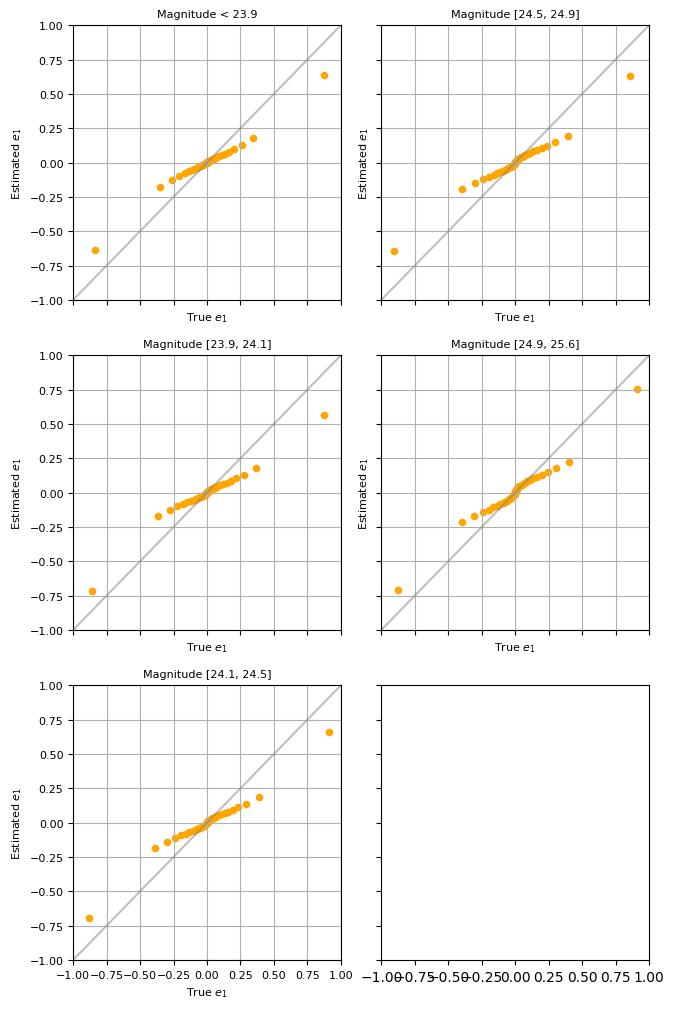

In [24]:
fig = plot_ellipticity_qq_plot(e_num=1)
fig.show()

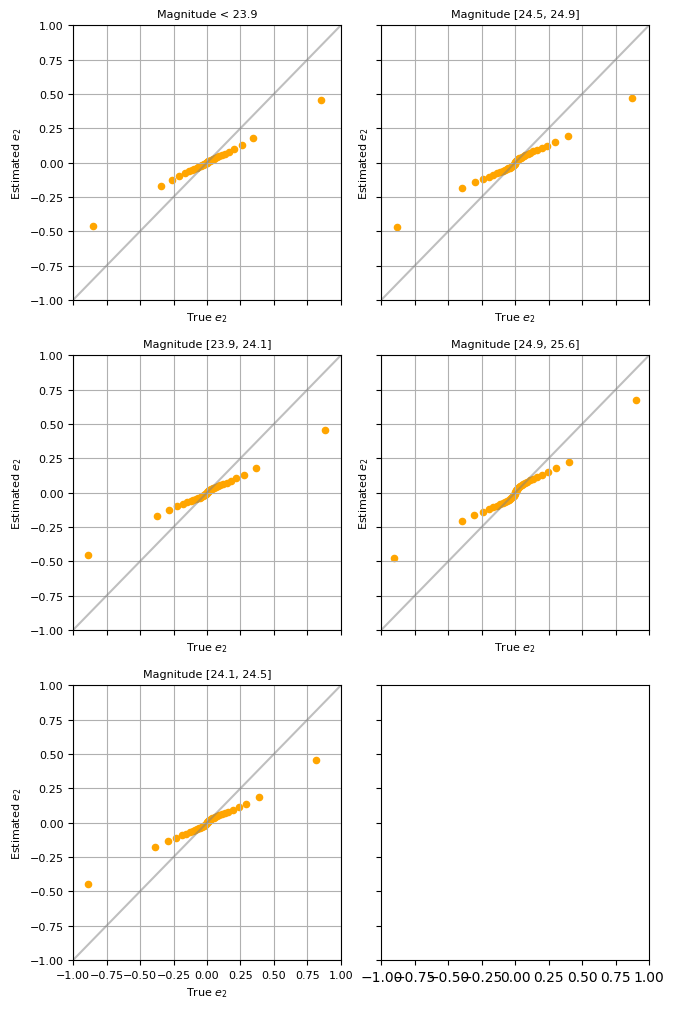

In [25]:
fig = plot_ellipticity_qq_plot(e_num=2)
fig.show()

In [19]:
dc2: DC2DataModule = instantiate(notebook_cfg.surveys.dc2)
test_sample = dc2.get_plotting_sample(0)
image = test_sample["image"]

In [20]:
true_tile_dict = DC2DataModule.unsqueeze_tile_dict(test_sample["tile_catalog"])
true_full_cat = TileCatalog(true_tile_dict).to_full_catalog(tile_slen=tile_slen)

In [21]:
e_output_dir = output_dir / "lsst_ellipticity_est"
e_output_dir.mkdir(exist_ok=True)

In [22]:
def plot_ellipticity_on_image(true_full_cat: FullCatalog, image: torch.Tensor):
    for i in range(0, image_lim, sub_image_len):
        for j in range(0, image_lim, sub_image_len):
            plocs_box_origin = torch.tensor([i, j])
            cur_target_full_cat = true_full_cat.filter_by_ploc_box(plocs_box_origin, 
                                                                   sub_image_len)
            image_sub = image[:, i:(i + sub_image_len), j:(j + sub_image_len)]
            image_sub_0_1 = ((image_sub + 0.5).norm(dim=0, p=1) / len(bands)).clamp(min=0, max=1)
            image_sub = (image_sub_0_1 * 255).clamp(min=0, max=255)

            true_df = pd.DataFrame({
                "id": cur_target_full_cat["objid"].flatten(),
                "plocs_x": cur_target_full_cat["plocs"][0, :, 1],
                "plocs_y": cur_target_full_cat["plocs"][0, :, 0],
            })
            est_ellip_df = true_df.merge(cat,
                                           left_on="id",
                                           right_on="id",
                                           how="left")
            est_ellip_df.dropna(subset=["id", "plocs_x", "plocs_y",
                                        "ellipticity_1_est", "ellipticity_2_est",
                                        "ellipticity_1_true", "ellipticity_2_true"],
                                inplace=True)
            est_ellip_df = est_ellip_df[["id", "plocs_x", "plocs_y",
                                        "ellipticity_1_est", "ellipticity_2_est",
                                        "ellipticity_1_true", "ellipticity_2_true"]]

            fig, ax = plt.subplots(figsize=(NoteBookPlottingParams.figsize[0] * 2,
                                            NoteBookPlottingParams.figsize[1] * 2))
            ax.imshow(image_sub, cmap="gray", vmin=0, vmax=255)
            ax.scatter(est_ellip_df["plocs_x"], 
                       est_ellip_df["plocs_y"], 
                       marker="x",
                       color="blue")
            
            for _i, row in est_ellip_df.iterrows():
                e1_est = row["ellipticity_1_est"]
                e2_est = row["ellipticity_2_est"]
                e1_true = row["ellipticity_1_true"]
                e2_true = row["ellipticity_2_true"]
                ax.text(row["plocs_x"] + 0.2, row["plocs_y"] + 0.2, 
                        f"e1_est={e1_est: .3f}; e2_est={e2_est: .3f};\ne1_true={e1_true: .3f}; e2_true={e2_true: .3f}", 
                        fontsize=NoteBookPlottingParams.fontsize,
                        color="red")

            ax.tick_params(labelsize=NoteBookPlottingParams.fontsize * 2)

            fig.savefig(e_output_dir / f"image_{i}_{j}.pdf",
                        bbox_inches="tight",
                        dpi=NoteBookPlottingParams.dpi)
            fig.show()
            plt.close()

In [ ]:
plot_ellipticity_on_image(true_full_cat, image)